# Exploring Evolutionary Algorithms w/ DEAP

In this section we define a set of utilities to download stock data and calculate financial metrics to be used for our downstream Evolutionary Algorithm. 

In [1]:
# Utilities
from datetime import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
import pickle

def get_ticker_data(ticker: str, start: datetime, end: datetime) -> pd.DataFrame:
    """ Download stock datafrom Yahoo Stocks. Method takes in a stock symbol, start date and end date and
        returns 
    """
    return pdr.get_data_yahoo(ticker, start=start, end=end)

def calculate_cagr(df: pd.DataFrame) -> float:
    days = (df.index[-1] - df.index[0]).days
    return ((((df['Adj Close'][-1]) / df['Adj Close'][1])) ** (365.0/days)) - 1


# Generate cache of stock data. For simulation we'll sample 150 stocks from the 
# SP500 and gather relevant data and calculate the compound annual growth rate.

# symbols = pd.read_csv("data/sp500_symbols.csv")["Symbol"].tolist()

# stock_subset = np.random.choice(symbols, size=150)

# stock_map = {}
# eval_start = datetime(2015, 1, 1) 
# eval_end =  datetime(2019, 12, 31)
        
# for stock in tqdm(stock_subset):
#     try:
#         df = get_ticker_data(stock, eval_start, eval_end)
#         cagr = calculate_cagr(df)
#         stock_map[stock] = {"df": df, "cagr": cagr}
#     except:
#         # Not all stocks in our sample will have data going back to 2015. We'll skip those stocks
#         continue

# pickle.dump(stock_map, open("data/stock_data.pkl", "wb"))
stock_map = pickle.load(open("data/stock_data.pkl", "rb"))

## Create Stock Info Class
Next we create a class that will be used to generate random portfolios and look up CAGR values. DEAP requires a generator function to create individuals. In our simulation an individual is portfolio consisting of randomly selcted stocks. 

In [100]:
class StockManager():

    def __init__(self, portfolio_size: int, stock_map: dict):        
        self.portfolio_size = portfolio_size

        self.stock_info = stock_map
        self.stocks = sorted(self.stock_info.keys()) # Dict keys are unsorted. Sorting ensures deterministic indices
        self.stock_total = len(self.stocks)

        # convert stocks to ids
        self.stock2idx = {stock: idx for idx, stock in enumerate(self.stocks)}
        self.idx2stock = {idx:stock for idx, stock in enumerate(self.stocks)} 

    def lookup_stock(self, idx: int) -> str:
        return self.idx2stock[idx]

    def lookup_stock_cagr(self, idx) -> float:
        return self.stocks_info[self.lookup_stock(idx)]["cagr"]
    
    def generate_random_stocks(self) -> List[str]:
        """ Sample stocks from stock list to fill portfolio. """
        return np.random.choice(self.stocks, size = self.portfolio_size)
    
    def score_portfolio(self, portfolio: List[int]) -> float:
        cagr_total = 0
        for idx, val in enumerate(portfolio):
            cagr_total += self.stock_info[self.idx2stock[idx]]["cagr"] * val
        return cagr_total

    def generate_random_portfolio(self) -> List[int]:
        """ Generate a random portfolio. Portfolio is represented as indexed mask
            where each element index corresponds to a stock in the overall stock list.
            A 1 indicates a stock is part of the portfolio and a 0 indicate it is absent. 
        """
        random_stocks = self.generate_random_stocks()
        portfolio = [0] * len(self.stocks)
        for stock in random_stocks:
            portfolio[self.stock2idx[stock]] = 1
        return portfolio

In [101]:
stock_manager = StockManager(portfolio_size=20, stock_map=stock_map)

In [109]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random

POPULATION_SIZE = 50
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 1

def evaluate_portfolio(portfolio: List[int]) -> tuple:
    """  """
    return stock_manager.score_portfolio(portfolio),


In [116]:
ind = toolbox.individual()

In [117]:
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("attr_bool", random.random)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=stock_manager.stock_total)
 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_portfolio)

In [118]:
evaluate_portfolio(toolbox.individual())

(8.864909204755545,)

In [119]:
toolbox.register("mate", tools.cxTwoPoint)
 
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
 
toolbox.register("select", tools.selTournament, tournsize=3)


In [123]:
pop = toolbox.population(n=5)
 
hof = tools.HallOfFame(1)
 
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg    	min    	max    
0  	5     	8.48796	8.00066	9.15681
1  	3     	8.26895	7.32067	8.80086
2  	1     	8.47588	8.06679	8.80086
3  	0     	8.68041	8.60011	8.80086
4  	4     	8.42038	7.37957	8.80086
5  	2     	8.80086	8.80086	8.80086
6  	3     	8.68738	8.23347	8.80086
7  	2     	8.45663	7.07969	8.80086
8  	2     	8.6574 	8.08356	8.80086
9  	4     	8.71604	8.37677	8.80086
10 	2     	8.58881	7.74059	8.80086
11 	3     	8.54014	7.49724	8.80086
12 	5     	8.54951	8.12731	8.80086
13 	0     	8.80086	8.80086	8.80086
14 	2     	8.66738	8.13345	8.80086
15 	2     	8.80086	8.80086	8.80086
16 	0     	8.80086	8.80086	8.80086
17 	3     	8.48356	7.21437	8.80086
18 	2     	8.36676	6.89536	8.80086
19 	2     	8.41976	6.89536	8.80086
20 	4     	8.51448	7.98001	8.80086
21 	4     	8.80086	8.80086	8.80086
22 	4     	8.80086	8.80086	8.80086
23 	2     	8.63045	7.94879	8.80086
24 	1     	8.69875	8.29029	8.80086
25 	2     	8.80086	8.80086	8.80086
26 	2     	8.63031	7.94809	8.80086
27 	4     	8.64544	8

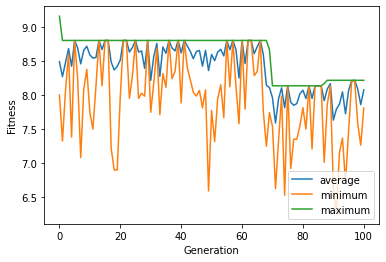

In [126]:
import matplotlib.pyplot as plt
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show() 

In [127]:
hof[0]

[0.7605915290842815,
 0.3963103950102127,
 0.39541855652899305,
 0.925634335391974,
 0.13895353928712628,
 0.5050289736471686,
 0.8298602063715956,
 0.9272468975789104,
 0.6711051864363156,
 0.9791907695552184,
 0.5227464240463555,
 0.6615172698522919,
 0.7829818008104352,
 0.29660799891740874,
 0.48634305461602,
 0.40510314053732166,
 0.10275794718719933,
 0.7510209377083393,
 0.2259462432499555,
 0.5509424052575599,
 0.06865296196988702,
 0.7633544265027671,
 0.7206985988872593,
 0.7524956461812884,
 0.006459931993083146,
 0.4024054490013991,
 0.783089969597162,
 0.15143354634191908,
 0.1428041245920343,
 0.5968692177750308,
 0.002913355894464398,
 0.21135328086909067,
 0.16079108136649667,
 0.0034472422438754924,
 0.1485484647770905,
 0.685331711422823,
 0.3657054913293327,
 0.4659352817175627,
 0.9109865143462084,
 0.9315336063981948,
 0.46226017088722027,
 0.3608242110504155,
 0.1333297741098095,
 0.5967568448494059,
 0.21972794216939018,
 0.868467819140884,
 0.8053410895101073,
 